In [2]:
%matplotlib inline
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, qiime2 as q2
from biom import load_table, Table
from biom.util import biom_open
from skbio import OrdinationResults
from emperor import Emperor, nbinstall; nbinstall()
plt.rcParams['svg.fonttype'] = 'none'

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [3]:
mf = load_mf('data/11546_20190118-122918.txt', 'sample_name')

In [4]:
table = q2.Artifact.load('data/feature-table.qza')
ms = table.view(Table)

Let's look at the distribution of counts per sample. 40K samples looks like a good value, note that samples with small counts are blanks.

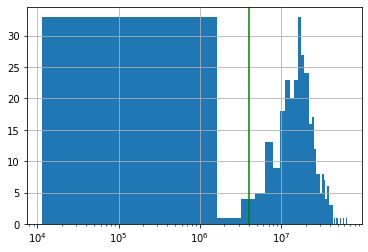

In [5]:
pd.Series(ms.filter(mf.index.intersection(ms.ids()), inplace=False).sum('sample')).hist(bins=40)
plt.gca().set_xscale('log')
plt.axvline(x=4000000, color='g')

Filter to keep only blanks and samples with more than 40K counts.

In [6]:
!qiime diversity alpha \
--i-table data/feature-table.noblanks.40k.qza \
--p-metric shannon \
--o-alpha-diversity shannon.qza

Saved SampleData[AlphaDiversity] to: shannon.qza


In [6]:
mf['shannon'] = q2.Artifact.load('shannon.qza').view(pd.Series)

In [7]:
mf.surgery_type.replace({
    'none': 'n',
    'partial_colectomy': 'colectomy'
}, inplace=True)

In [8]:
mf['complications'] = mf.crohns_disease_behavior.isin(['stricturing', 'fistulizing'])

In [9]:
mf = mf.query('empo_1 == "Host-associated"').copy()

Verify the numbers of samples per group 

In [10]:
repl = {'surgery_type': {
    'ileocolonic': 'Ileocolonic',
    'n': 'No surgery',
    'colectomy': 'Colectomy'
}}
mf.replace(repl).groupby('complications').surgery_type.value_counts()

complications  surgery_type
False          No surgery      223
               Colectomy        42
               Ileocolonic      21
True           Ileocolonic      30
               No surgery       21
               Colectomy        15
Name: surgery_type, dtype: int64

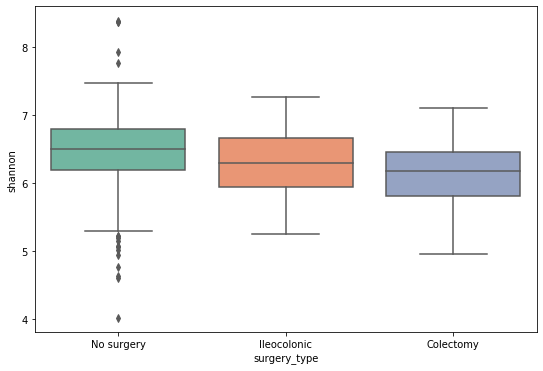

In [13]:
colors = {
    'Ileocolonic': '#fc8d62',
    'Colectomy': '#8da0cb',
    'No surgery': '#66c2a5',
}

repl = {'surgery_type': {
    'ileocolonic': 'Ileocolonic',
    'n': 'No surgery',
    'colectomy': 'Colectomy'
}}
fig, ax = plt.subplots(figsize=(9, 6))

sns.boxplot(x='surgery_type', y='shannon',
            data=mf.replace(repl), ax=ax,
            order=['No surgery', 'Ileocolonic', 'Colectomy'],
            palette=colors
           )

# for i, name in enumerate(['n', 'ileocolonic', 'colectomy']):
#     i = i * 2
#     ax.artists[i].set_color(colors[name])
#     ax.artists[i + 1].set_facecolor('white')
#     ax.artists[i + 1].set_edgecolor(colors[name])

# ax.get_legend().set_visible(False)

fig.savefig('shannon.complications.pdf', transparent=True)